In [ ]:
from traitlets.config.manager import BaseJSONConfigManager
import jupyter_core
path = "/Users/i.oseledets/anaconda2/envs/teaching/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update("livereveal", {
              "theme": "sky",
              "transition": "zoom",
              "start_slideshow_at": "selected",
              "scroll": True
})

# Lecture 11:  Great Iterative Methods

## Previous lecture

- Gaussian elimination and graphs in more details
- Concept of **iterative methods** for linear systems:
    - Richardson iteration and its convergence 
    - Chebyshev iteration

## Missed experiment from the previous lecture

- Compare Richardson and Chebyshev convergence
- In theory, for $A = A^* > 0$
    - Richardson method gives linear convergence rate with $q = \frac{\lambda_{\max} - \lambda_{\min}}{\lambda_{\max} + \lambda_{\min}} = \frac{\mathrm{cond}(A) - 1}{\mathrm{cond}(A)+1}$
    - Chebyshev method gives linear convergence rate, but with $q = \frac{\sqrt{\mathrm{cond}(A)}-1}{\sqrt{\mathrm{cond}(A)}+1}$

(array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
 <a list of 5 Text yticklabel objects>)

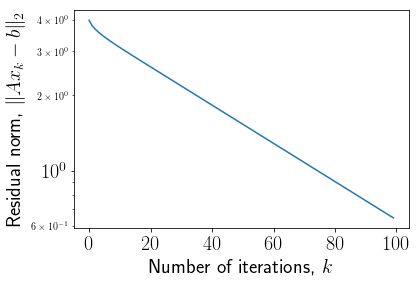

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True)
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg as spla
import scipy
from scipy.sparse import csc_matrix
n = 16
ex = np.ones(n);
A = sp.sparse.spdiags(np.vstack((-ex,  2*ex, -ex)), [-1, 0, 1], n, n, 'csr'); 
rhs = np.ones(n)
ev1, vec = spla.eigsh(A, k=2, which='LA')
ev2, vec = spla.eigsh(A, k=2, which='SA')
lam_max = ev1[0]
lam_min = ev2[0]

tau_opt = 2.0/(lam_max + lam_min)

fig, ax = plt.subplots()
plt.close(fig)

niters = 100
x = np.zeros(n)
res_richardson = []
for i in range(niters):
    rr = A.dot(x) - rhs
    x = x - tau_opt * rr
    res_richardson.append(np.linalg.norm(rr))
#Convergence of an ordinary Richardson (with optimal parameter)
plt.semilogy(res_richardson)
plt.xlabel("Number of iterations, $k$", fontsize=20)
plt.ylabel("Residual norm, $\|Ax_k - b\|_2$", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

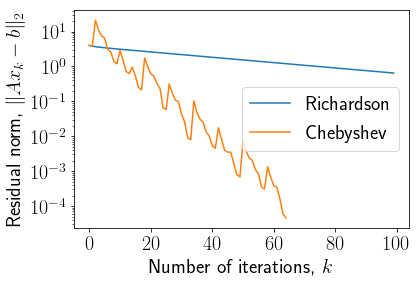

In [4]:
niters = 64
roots = [np.cos((np.pi * (2 * i + 1)) / (2 * niters)) for i in range(niters)]
taus = [(lam_max + lam_min - (lam_min - lam_max) * r) / 2 for r in roots]
x = np.zeros(n)
r = A.dot(x) - rhs
res_cheb = [np.linalg.norm(r)]

# Implementation may be non-optimal if number of iterations is not power of two
def good_shuffle(idx):
    if len(idx) == 1:
        return idx
    else:
        new_len = int(np.ceil((len(idx) / 2)))
        new_idx = good_shuffle(idx[:new_len])
        res_perm = []
        perm_count = 0
        for i in new_idx:
            res_perm.append(i)
            perm_count += 1
            if perm_count == len(idx):
                break
            res_perm.append(len(idx) + 1 - i)
            perm_count += 1
            if perm_count == len(idx):
                break
        return res_perm

good_perm = good_shuffle([i for i in range(1, niters+1)])
# good_perm = [i for i in range(niters, 0, -1)]
# good_perm = np.random.permutation([i for i in range(1, niters+1)])

for i in range(niters):
    x = x - 1.0/taus[good_perm[i] - 1] * r
    r = A.dot(x) - rhs
    res_cheb.append(np.linalg.norm(r))
    
plt.semilogy(res_richardson, label="Richardson")
plt.semilogy(res_cheb, label="Chebyshev")
plt.legend(fontsize=20)
plt.xlabel("Number of iterations, $k$", fontsize=20)
plt.ylabel("Residual norm, $\|Ax_k - b\|_2$", fontsize=20)
plt.xticks(fontsize=20)
_ = plt.yticks(fontsize=20)

### What happened with great Chebyshev iterations?

- Permutation of roots of Chebyshev polynomial has crucial effect on convergence
- On the optimal permutation you can read in paper (V. Lebedev, S. Finogenov 1971)  ([ru](http://www.mathnet.ru/links/42ab1a270ad179d43359ef8fab53422c/zvmmf6870.pdf), [en](https://www.sciencedirect.com/science/article/abs/pii/0041555371901698?via%3Dihub))

## Today lecture
- Lanczos and Arnoldi orthogonalization of Krylov subspaces, optimality result for Krylov subspaces
- Main iterative methods: conjugate gradient, GMRES, etc
- Convergence estimates

## Solution of linear systems and minimization of functionals

Instead of solving a linear system, we can minimize the **residual:**

$$R(x) = \Vert A x - f \Vert_2.$$

The condition $\nabla R(x) = 0$ gives

$$A^* A x = A^* f,$$

thus it has squared condition number, so direct minimization of the residual by standard optimization methods is rarely used.

For the symmetric positive definite case there is a much simpler functional.

## Energy functional

Let $A = A^* > 0$, then the following functional 

$$\Phi(x) = (Ax, x)  - 2(f, x)$$

is called **energy functional**.

### Properties of energy functional
- It is strictly convex (check!)

$$ \Phi(\alpha x + (1 - \alpha)y) < \alpha \Phi(x) + (1 - \alpha) \Phi(y)$$

- Since it is strictly convex, it has unique local minimum, which is also global

- Its global minimum $x_*$ satisfies

$$A x_* = f.$$

Indeed, 

$$\nabla \Phi = 2(Ax - f).$$ 

and the first order optimality condition $\nabla \Phi (x_*) = 0$ yields

$$A x_* = f.$$

## Approximation of the solution by a subspace

Given a linear $M$-dimensional subspace $\{y_1, \dots, y_M\}$, we want to find an approximate solution in this basis, i.e. 

$$A x \approx f, \quad x = \sum_{k=1}^M c_k y_k,$$

where $c$ is the vector of coefficients.

In the symmetric positive definite case  we need to minimize 

$$(Ax, x) - 2(f, x)$$ 

subject to $$x = Y c,$$

where $Y=[y_1,\dots,y_M]$ is $n \times M$ and vector $c$ has length $M$.

Using the representation of $x$, we have the following minimization for $c$:

$$\widehat{\Phi}(c) = (A Y c, Y c) - 2(f, Y c) = (Y^* A Y c, c) - 2(Y^* f, c).$$

Note that this is the same functional, but for the **Galerkin projection** of $A$

$$Y^* A Y c = Y^* f,$$

which is an $M \times M$  linear system with symmetric positive definite matrix if $Y$ has full column rank.

But how to choose $Y$?

## Selection of the subspace

In the Krylov subspace we generate the whole subspace from a single vector $r_0 = f - Ax_0$:

$$y_0\equiv k_0 = r_0, \quad y_1\equiv k_1 = A r_0, \quad y_2\equiv k_2 = A^2 r_0, \ldots, \quad y_{M-1}\equiv k_{M-1} = A^{M-1} r_0.$$

This gives the **Krylov subpace** of the $M$-th order

$$\mathcal{K}_M(A, r_0) = \mathrm{Span}(r_0, Ar_0, \ldots, A^{M-1} r_0).$$

- It is known to be quasi-optimal space given only matrix-vector product operation.
- Key reference here is "On the numerical solution of equation by which are determined in technical problems the frequencies of small vibrations of material systems",  A. N. Krylov, 1931, [text in russian](http://www.mathnet.ru/links/a2431bc65c0764da9a1ae95c73f741f6/im5215.pdf)

## Solution $x_*$ lies in the Krylov subspace: $x_* \in \mathcal{K}_n(A, f)$

- According to [Cayley–Hamilton theorem](https://en.wikipedia.org/wiki/Cayley%E2%80%93Hamilton_theorem): $p(A) = 0$, where $p(\lambda) = \det(A - \lambda I)$
- $p(A)f = A^nf + a_1A^{n-1}f + \ldots + a_{n-1}Af + a_n f = 0$
- $A^{-1}p(A)f = A^{n-1}f + a_1A^{n-2}f + \ldots + a_{n-1}f + a_nA^{-1}f = 0$
- $x_* = A^{-1}f = -\frac{1}{a_n}(A^{n-1}f + a_1A^{n-2}f + \ldots + a_{n-1}f)$
- Thus, $x_* \in \mathcal{K}_n(A, f)$

## Ill-conditioned of the natural basis

The natural basis in the Krylov subspace is very **ill-conditioned**, since 

$$k_i = A^i r_0 \rightarrow \lambda_\max^i v,$$

where $v$ is the eigenvector, corresponding to the maximal eigenvalue of $A$,

i.e. $k_i$ become more and more collinear for large $i$.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as spsp
%matplotlib inline

n = 100
ex = np.ones(n);
A = spsp.spdiags(np.vstack((-ex,  2*ex, -ex)), [-1, 0, 1], n, n, 'csr'); 
f = np.ones(n)
x0 = np.random.randn(n)

subspace_order = 10
krylov_vectors = np.zeros((n, subspace_order))
krylov_vectors[:, 0] = f - A.dot(x0)
for i in range(1, subspace_order):
    krylov_vectors[:, i] = A.dot(krylov_vectors[:, i-1])
    
s = np.linalg.svd(krylov_vectors, compute_uv=False)
print("Condition number = {}".format(s.max() / s.min()))

Condition number = 595184527.1939951


**Solution:** Compute orthogonal basis in the Krylov subspace.

## Good basis in a Krylov subspace

In order to have stability, we first orthogonalize the vectors from the Krylov subspace using **Gram-Schmidt** orthogonalization process (or, QR-factorization).

$$K_j = \begin{bmatrix} r_0 & Ar_0 & A^2 r_0 & \ldots & A^{j-1} r_0\end{bmatrix} = Q_j R_j, $$

and the solution will be approximated as $$x \approx x_0 + Q_j c.$$ 


## Short way to Arnoldi relation

**Statement.** The Krylov matrix $K_j$ satisfies an important recurrent relation (called **Arnoldi relation**)

$$A Q_j = Q_j H_j + h_{j, j-1} q_j e^{\top}_{j-1},$$

where $H_j$ is upper Hessenberg, and  $Q_{j+1} = [q_0,\dots,q_j]$ has orthogonal columns that spans columns of $K_{j+1}$.

Let us prove it (consider $j = 3$ for simplicity):

$$A \begin{bmatrix} k_0 & k_1 & k_2 \end{bmatrix} = \begin{bmatrix} k_1 & k_2 & k_3 \end{bmatrix} = \begin{bmatrix} k_0 & k_1 & k_2 \end{bmatrix} \begin{bmatrix} 0 & 0 & \alpha_0 \\ 1 & 0  & \alpha_1 \\ 0 & 1  & \alpha_2 \\ \end{bmatrix} + \begin{bmatrix} 0 & 0 & k_3  - \alpha_0 k_0 - \alpha_1 k_1 - \alpha_2 k_2 \end{bmatrix}, $$
 
where $\alpha_s$ will be selected later. 
Denote $\widehat{k}_3 = k_3  - \alpha_0 k_0 - \alpha_1 k_1 - \alpha_2 k_2$.
 
 In the matrix form,
 
 $$A K_3 = K_3 Z + \widehat k_3 e^{\top}_2,$$
 
 where $Z$ is the **lower shift** matrix with the last column $(\alpha_0,\alpha_1,\alpha_2)^T$, and $e_2$ is the last column of the identity matrix.
 
 Let $$K_3 = Q_3 R_3$$ be the QR-factorization. Then,
 
 $$A Q_3 R_3 = Q_3 R_3 Z + \widehat{k}_3 e^{\top}_2,$$
 
 $$ A Q_3 = Q_3 R_3 Z R_3^{-1} + \widehat{k}_3 e^{\top}_2 R_3^{-1}.$$


Note that 

$$e^{\top}_2 R_3^{-1} = \begin{bmatrix} 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} * & * & * \\ 0 & * & * \\ 0 & 0 & * \end{bmatrix}  = \gamma e^{\top}_2,$$
 and
 
 $$R_3 Z R_3^{-1} = \begin{bmatrix} * & * & * \\* & * & * \\  0 & * & * \\ \end{bmatrix},$$      

in the general case it will be an **upper Hessenberg matrix** $H$, i.e. a matrix 
that 

$$H_{ij} = 0, \quad \mbox{if } i > j + 1.$$

## (Almost) Arnoldi relation

Let $Q_j$ be the orthogonal basis in the Krylov subspace, then we have almost the Arnoldi relation

$$A Q_j = Q_j H_j +  \gamma\widehat{k}_j e^{\top}_{j-1},$$

where $H_j$ is an upper Hessenberg matrix, and 

$$\widehat{k}_j = k_j - \sum_{s=0}^{j-1} \alpha_s k_s.$$

We select $\alpha_s$ in such a way that 

$$Q^*_j \widehat{k}_j = 0.$$

Then, $\widehat{k}_j = h_{j, j-1} q_j,$ where $q_j$ is the last column of $Q_{j+1}$.

## Arnoldi relation: final formula

We have 

$$A Q_j = Q_j H_j + h_{j, j-1} q_j e^{\top}_{j-1}.$$

- This is the crucial formula for the efficient generation of such subspaces.

- For non-symmetric case, it is just modified Gram-Schmidt.

- For the symmetric case, we have a much simpler form (Lanczos process).

## Lanczos process

If $A = A^*$, then

$$Q^*_j A Q_j = H_j, $$

thus $H_j$ is hermitian, and thus it is **tridiagonal**, $H_j = T_j$.

This gives a short-term recurrence relation to generate the Arnoldi vectors $q_j$ without **full** orthogonalization.

## Lanczos process (2)

$$ A Q_j = Q_j T_j + t_{j, j-1} q_j e^{\top}_{j-1}.$$


In order to get $q_j$, we need to compute just the last column of 

$$t_{j, j-1} q_j = (A Q_j - Q_j T_j) e_{j-1} = A q_{j-1} - t_{j-1, j-1} q_{j-1} - t_{j-2, j-1} q_{j-2}. $$

The coefficients $\alpha_j = t_{j-1, j-1}$ and $\beta_j = t_{j-2, j-1}$ can be recovered from orthogonality constraints 

$(q_j, q_{j-1}) = 0, \quad (q_j, q_{j-2}) = 0$

**All the other constraints will be satisfied automatically!!**

And we only need to store two vectors to get the new one.

## From direct Lanczos method to the conjugate gradient

We can now get from the Lanczos recurrence to the famous **conjugate gradient** method.

We have for $A = A^* > 0$

$$A Q_j = Q_j T_j + T_{j, j-1} q_j.$$

Recall that when we minimize energy functional in basis $Y$ we get a system $Y^* A Y c = Y^* f,$.
Here $Y = Q_j$, so the approximate solution of $Ax \approx f$ with $x_j = x_0 + Q_j c_j$ can be found by solving a small system

$$Q^*_j A Q_j c_j = T_j c_j = Q^*_j r_0 .$$

Since $f$ is the first Krylov subspace, then 
**Note!!!** (recall what the first column in $Q_j$ is)

$$Q^*_j r_0  = \Vert r_0 \Vert_2^2 e_0 = \gamma e_0.$$

We have a tridiagonal system of equations for $c$:

$$T_j c_j = \gamma e_0$$

and $x_j = Q_j c_j$.

We could stop at this point, but we want short recurrent formulas instead of solving linear system with matrix $T_j$ at each step.

**Derivation of the following update formulas is not required on the oral exam!**

- Since $A$ is positive definite, $T_j$ is also positive definite, and it allows an LU decomposition

- $T_j = L_j U_j$, where $L_j$ is a bidiagonal matrix with ones on the diagonal, $U_j$ is a upper bidiagonal matrix.

- We need to define one subdiagonal in $L$ (with elements $c_1, \ldots, c_{j-1}$), main diagonal of $U_j$ (with elements $d_0, \ldots, d_{j-1}$ and superdiagonal of $U_j$ (with elements $b_1, \ldots, b_{j-1}$).

- They have convenient recurrences:

$$c_i = b_i/d_{i-1}, \quad d_i = \begin{cases} a_1, & \mbox{if } i = 0, \\
a_i - c_i b_i, & \mbox{if } i > 0. \end{cases}$$

- For the solution we have

$$x_j = Q_j T^{-1}_j \gamma e_0  = \gamma Q_j (L_j U_j)^{-1} e_0  = \gamma Q_j U^{-1}_j L^{-1}_j e_0.$$

- We introduce two new quantities:  

$$P_j = Q_j U^{-1}_j, \quad z_j = \gamma L^{-1}_j e_0.$$

- Due to the recurrence relations, we have

$$P_j = \begin{bmatrix} P_{j-1} & p_j \end{bmatrix}, $$

and 

$$z_j = \begin{bmatrix} z_{j-1} \\ \xi_{j} \end{bmatrix}.$$

- For $p_j$ and $\xi_j$ we have short-term recurrence relations (due to bidiagonal structure)

$$p_j = \frac{1}{d_j}\left(q_j - b_j p_{j-1} \right), \quad \xi_j = -c_j \xi_{j-1}.$$

- Thus, we arrive at short-term recurrence for $x_j$:

$$x_j = P_j z_j = P_{j-1} z_{j-1} + \xi_j p_j = x_{j-1} + \xi_j p_j.$$
and $q_j$ are found from the Lanczos relation (see slides above).

- This method for solving linear systems is called a **direct Lanczos method**. It is closely related to the conjugate gradient method.

## Direct Lanczos method

We have the direct Lanczos method, where we store 

$$p_{j-1}, q_j, x_{j-1}$$ to get a new estimate of $x_j$.

The main problem is with $q_j$: we have the three-term recurrence, but in the floating point arithmetic 
the orthogonality is can be lost, leading to numerical errors.

Let us do some demo.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp
import scipy.sparse as spsp
from scipy.sparse import csc_matrix

n = 128
ex = np.ones(n);
A = spsp.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
rhs = np.ones(n)

nit = 64
q1 = rhs/np.linalg.norm(rhs)
q2 = A.dot(q1)
q2 = q2 - np.dot(q2, q1)*q1
q2 = q2/np.linalg.norm(q2)
qall = [q1, q2]
for i in range(nit):
    qnew = A.dot(qall[-1])
    qnew = qnew - np.dot(qnew, qall[-1])*qall[-1]
    qnew = qnew/np.linalg.norm(qnew)
    qnew = qnew - np.dot(qnew, qall[-2])*qall[-2]
    qnew = qnew/np.linalg.norm(qnew)
    qall.append(qnew)
qall_mat = np.vstack(qall).T
print(np.linalg.norm(qall_mat.T.dot(qall_mat) - np.eye(qall_mat.shape[1])))

1.6432256263275


## Conjugate gradient method

Instead of $q_j$ (last vector in the modified Gram-Schmidt process), it is more convenient to work with the **residual**

$$r_j = f - A x_j.$$

The resulting recurrency has the form

$x_j = x_{j-1} + \alpha_{j-1} p_{j-1}$

$r_j = r_{j-1} - \alpha_{j-1}  A p_{j-1}$

$p_j = r_j + \beta_j p_{j-1}$.

Hence the name conjugate gradient: to the gradient $r_j$ we add a **conjugate direction** $p_j$.

We have **orthogonality** of residuals (check!):

$$(r_i, r_j) = 0, \quad i \ne j$$

and **A-orthogonality** of conjugate directions (check!):

$$ (A p_i, p_j) = 0,$$

which can be checked from the definition.

The equations for $\alpha_j$ and $\beta_j$ can be now defined explicitly from these two properties.

## CG final formulas

We have $(r_{j}, r_{j-1}) = 0 = (r_{j-1} - \alpha_{j-1} A r_{j-1}, r_{j-1})$, 

thus

$$\alpha_{j-1} = \frac{(r_{j-1}, r_{j-1})}{(A r_{j-1}, r_{j-1})}.$$

In the similar way, we have

$$\beta_{j-1} = \frac{(r_j, r_j)}{(r_{j-1}, r_{j-1})}.$$

Recall that

$x_j = x_{j-1} + \alpha_{j-1} p_{j-1}$

$r_j = r_{j-1} - \alpha_{j-1}  A p_{j-1}$

$p_j = r_j + \beta_j p_{j-1}$.

Only one matrix-by-vector product per iteration.


## CG derivation overview

- Want to find $x_*$ in Krylov subspace
- But natural basis in ill-conditioned, therefore we need orthogonalization
- Derive recurrent equation for sequential orthogonalization of the Krylov subspace basis
    - Arnoldi process for non-symmetric matrix
    - Lanczos process for symmetrix matrix
- Clever re-writing of these formulas gives short recurrence 

## Some history
More details here: https://www.siam.org/meetings/la09/talks/oleary.pdf

When Hestenes worked on conjugate bases in 1936, he was advised by a
Harvard professor that it was too obvious for publication
- CG doesn’t work on slide rules.
<img src="./pics/slide_rule.jpg">
- CG has little advantage over Gauss elimination for computation with
calculators.
- CG is not well suited for a room of human "computers" – too much data exchange.
<img src="./pics/human_computers.jpg">

## Properties of the CG method

- We need to store 3 vectors.

- Since it generates $A$-orthogonal sequence $p_1, \ldots, p_N$, aften $n$ steps it should stop (i.e., $p_{N+1} = 0$.) 

- In practice it does not have this property in finite precision, thus after its invention in 1952 by Hestens and Stiefel it was labeled **unstable**.

- In fact, it is a brilliant iterative method.

## $A$-optimality


Energy functional can be written as 

$$(Ax, x) - 2(f, x) = (A (x - x_*), (x - x_*)) - (Ax _*, x_*),$$

where $A x_* = f$. Up to a constant factor,

$$ (A(x - x_*), (x -x_*)) = \Vert x - x_* \Vert^2_A$$

is the **A-norm** of the error.


## Convergence
The CG method computes $x_k$ that minimizes the energy functional over the Krylov subspace, i.e. $x_k = p(A)f$, where $p$ is a polynomial of degree $k+1$, so

$$\Vert x_k - x_* \Vert_A  =  \inf\limits_{p} \Vert \left(p(A) - A^{-1}\right) f \Vert_A. $$

Using eigendecomposition of $A$ we have

$$A = U \Lambda U^*, \quad  g = U^* f,$$ and

$\Vert x - x_* \Vert^2_A = \displaystyle{\inf_p} \Vert \left(p(\Lambda) - \Lambda^{-1}\right) g \Vert_\Lambda^2 = \displaystyle{\inf_p}
\displaystyle{\sum_{i=1}^n} \frac{(\lambda_i p(\lambda_i) - 1)^2 g^2_i}{\lambda_i} = \displaystyle{\inf_{q, q(0) = 1}} \displaystyle{\sum_{i=1}^n} \frac{q(\lambda_i)^2 g^2_i}{\lambda_i}
$

Selection of the optimal $q$ depends on the eigenvalue distribution.



## Absolute and relative error

We have
$$\Vert x - x_* \Vert^2_A \leq \sum_{i=1}^n \frac{g^2_i}{\lambda_i} \inf_{q, q(0)=1} \max_{j} q({\lambda_j})^2$$

The first term is just $$\sum_{i=1}^n \frac{g^2_i}{\lambda_i} = (A^{-1} f, f) = \Vert x_* \Vert^2_A.$$

And we have relative error bound

$$\frac{\Vert x - x_* \Vert_A }{\Vert x_* \Vert_A} \leq \inf_{q, q(0)=1} \max_{j} |q({\lambda_j})|,$$

so if matrix has only 2 different eigenvalues, then there exists a polynomial of degree 2 such that $q({\lambda_1}) =q({\lambda_2})=0$, so in this case CG converges in 2 iterations.

<font color='red'>
If eigenvalues are clustered and there are $l$ outliers, then after first $\mathcal{O}(l)$ iterations CG will converge as if there are no outliers (and hence the effective condition number is smaller). <br>
The intuition behind this fact is that after $\mathcal{O}(l)$ iterations the polynomial has degree more than $l$ and thus is able to zero $l$ outliers.
</font>

Let us find another useful upper-bound estimate of convergence. 
Since

$$
\inf_{q, q(0)=1} \max_{j} |q({\lambda_j})| \leq \inf_{q, q(0)=1} \max_{\lambda\in[\lambda_\min,\lambda_\max]} |q({\lambda})|
$$

The last term is just the same as for the Chebyshev acceleration, thus the same 
upper convergence bound holds:

$$\frac{\Vert x_k - x_* \Vert_A }{\Vert x_* \Vert_A} \leq \gamma \left( \frac{\sqrt{\mathrm{cond}(A)}-1}{\sqrt{\mathrm{cond}(A)}+1}\right)^k.$$

## Finite termination & clusters

1. If $A$ has only $m$ different eigenvalues, CG converges in $m$ iterations (proof in the blackboard).
2. If $A$ has $m$ "clusters" of eigenvalues, CG converges cluster-by-cluster.

As a result, better convergence than Chebyshev acceleration, but slightly higher cost per iteration.

## Summary

CG is the method of choice for symmetric positive definite systems:

1. $\mathcal{O}(n)$ memory
2. Square root of condition number in the estimates
3. Automatic ignoring of the outliers/clusters
4. $A$-optimality property

## Non-linear conjugate gradient method

- CG minimizes the energy functional, which is quadratic in $x$
- CG formulas were used as starting point in developing methods to minimize arbitrary convex function
- Most popular CG extensions (so-called non-linear CG method) are 
    - [Hestenes-Stiefel method](https://www.fing.edu.uy/inco/cursos/numerico/aln/hes_stief1952.pdf)
    - [Polak-Ribiere method](http://www.numdam.org/article/M2AN_1969__3_1_35_0.pdf) - original paper in French
    - [Fletcher–Reeves method](https://watermark.silverchair.com/070149.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAkMwggI_BgkqhkiG9w0BBwagggIwMIICLAIBADCCAiUGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMiWM0crDA8bZ0Fj5HAgEQgIIB9tIM8xbxhkhniJQifurRLHIaOcnos9gvgBj8Lkc34eBUtUg4oYzjusGP_FZiHfpBoRnM409FFCs-Y5xxomumnGRQ8UIZJe7CPSmaCcSklAdwHN3Ja-fHfALctP68U3mGGeR11P8vlESoS7HZhZEmVhFb5m7jPk1ENZKLlq9CnVTz2n2bI3HPYCfDIo8ywd8RWo5gw6EwYnZ46l1ExES8AHMqlklpgzdupLhL6HxTzBEHd_qY4B2FjK4m4MpvdaX5imEnOD6YCwZMNC_qLzUdPxumcXl4oTRDyJp1kg_6PcGi98hE10InOp4aHJeIjl5FPJnuEFEBcv28asOq4vngp6N5d-4y1fpeoxcAe4d857TeLtQnGD6LlCAL_3Mh0lQ8iYLLfjw4b_V2jHEuSxKH3BalLPMS5KF2nGqqrzfbDs8x9jW-OlkeL_x68Zidv0rTHqTd0ww3kvSINDjgw6owPMLK9KxEWP5T-4dnu_kn-NXR1W0s52kUHFD1U9AWs5Zzh4RTVOXsdjGQciWzOO-XieLn8Aju-0P8mVEGjUDOjLDZtuPYM-Ep_Z9lp8TNDCi2lB5IQFbKVpBFaAItDDyVUvKNPfBovmKlnPRFLZYjLbgocnU3tcy0YB8RZegC56Gxn7g_WkphptCVPm7IDeCE9l5gcFafuY0)

## Non-symmetric systems and the generalized minimal residual method (GMRES) [(Y. Saad, M. Schultz, 1986)](https://epubs.siam.org/doi/10.1137/0907058)

Before we discussed symmetric positive definite systems. What happens if $A$ is non-symmetric?

We can still orthogonalize the Krylov subspace using Arnoldi process, and get

$$A Q_j = Q_j H_j + h_{j,j-1}q_j e^{\top}_{j-1}.$$

Let us rewrite the latter expression as

$$ A Q_j = Q_j H_j + h_{j,j-1}q_j e^{\top}_{j-1} = Q_{j+1} \widetilde H_j, \quad \widetilde H_j = 
\begin{bmatrix} h_{0,0} & h_{0,1} & \dots & h_{0,j-2} & h_{0,j-1} \\ h_{1,0} & h_{1,1} & \dots & h_{1,j-2} & h_{1,j-1} \\ 0& h_{2,2} &  \dots & h_{2,j-2} & h_{2,j-1} \\
0& 0 & \ddots & \vdots & \vdots  \\
0& 0 &  & h_{j,j-1} & h_{j-1,j-1} \\ 0& 0 & \dots & 0 & h_{j,j-1}\end{bmatrix}$$

Then, if we need to minimize the residual over the Krylov subspace, we have

$$x_j = x_0 + Q_j c_j $$

and $x_j$ has to be selected as 

$$ \Vert A x_j - f \Vert_2 =  \Vert A Q_j c_j - r_0 \Vert_2 \rightarrow \min_{c_j}.$$

Using the Arnoldi recursion, we have

$$ \Vert Q_{j+1} \widetilde H_j c_j -  r_0 \Vert_2 \rightarrow \min_{c_j}.$$

Using the orthogonal invariance under multiplication by unitary matrix, we get

$$ \Vert \widetilde H_j c_j - \gamma e_0 \Vert_2 \rightarrow \min_{c_j},$$

where we have used that $Q^*_{j+1} r_0 = \gamma e_0.$

- This is just a linear least squares with $(j+1)$ equations and $j$ unknowns.

- The matrix is also upper Hesseberg, thus its QR factorization can be computed in a very cheap way.

- This allows the computation of $c_j$. This method is called **GMRES** (generalized minimal residual)

## Summary of the GMRES

- Minimizes the residual directly
- No normal equations
- Memory grows with the number of iterations as $\mathcal{O}(j^2)$, so **restarts** typically implemented (just start GMRES from the new initial guess).

<Figure size 720x360 with 0 Axes>

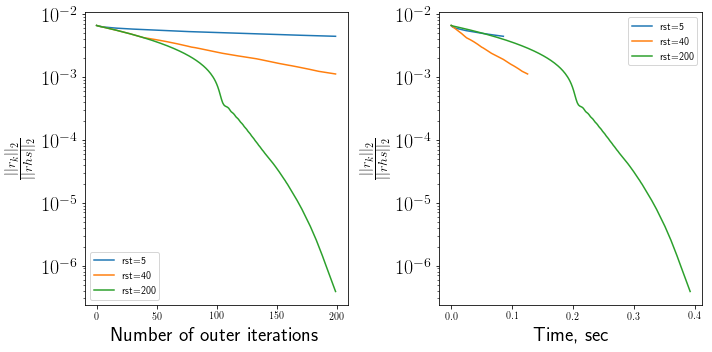

In [8]:
import scipy.sparse.linalg as la
from scipy.sparse import csc_matrix, csr_matrix
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline
n = 150
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
A = csr_matrix(A)
rhs = np.ones(n * n)

plt.figure(figsize=(10, 5))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
for restart in [5, 40, 200]:
    hist = []
    def callback(rk):
        hist.append(np.linalg.norm(rk) / np.linalg.norm(rhs))
    st = time.time()
    sol = la.gmres(A, rhs, x0=np.zeros(n*n), maxiter=200, restart=restart, callback=callback, tol=1e-16)
    current_time = time.time() - st
    ax1.semilogy(np.array(hist), label='rst={}'.format(restart))
    ax2.semilogy([current_time * i / len(hist) for i in range(len(hist))], np.array(hist), label='rst={}'.format(restart))
    

ax1.legend(loc='best')
ax2.legend(loc='best')
ax1.set_xlabel("Number of outer iterations", fontsize=20)
ax2.set_xlabel("Time, sec", fontsize=20)
ax1.set_ylabel(r"$\frac{||r_k||_2}{||rhs||_2}$", fontsize=20)
ax2.set_ylabel(r"$\frac{||r_k||_2}{||rhs||_2}$", fontsize=20)
plt.sca(ax1)
plt.yticks(fontsize=20)
plt.sca(ax2)
plt.yticks(fontsize=20)
f.tight_layout()

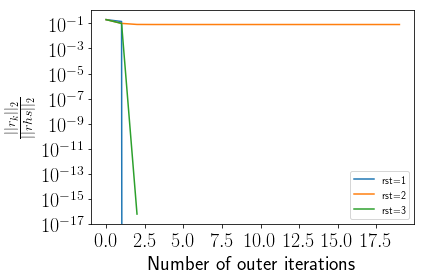

In [9]:
import scipy.sparse.linalg as la
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Example from http://www.caam.rice.edu/~embree/39961.pdf

A = np.array([[1, 1, 1],
              [0, 1, 3],
              [0, 0, 1]]
            )
rhs = np.array([2, -4, 1])
x0 = np.zeros(3)

for restart in [1, 2, 3]:
    hist = []
    def callback(rk):
        hist.append(np.linalg.norm(rk)/np.linalg.norm(rhs))
    _ = la.gmres(A, rhs, x0=x0, maxiter=20, restart=restart, callback=callback)
    plt.semilogy(np.array(hist), label='rst={}'.format(restart))
plt.legend()
plt.xlabel("Number of outer iterations", fontsize=20)
plt.ylabel(r"$\frac{||r_k||_2}{||rhs||_2}$", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()

## Next lecture

- Iterative methods continued (BiCG, Minres, QMR), preconditioners.


# Questions?

In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()